## Covid cases in the UK

This notebook analyses the COVID data in the UK. The data itself has been compiled by the UK government and is available through the website https://coronavirus.data.gov.uk/

First, let's import some necessary items

In [1]:
import pandas as pd
import io
import requests
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np

Now, let's define the urls from where the data will be downloaded, as csv files, these can also be downloaded as JSON.

In [2]:
url_cases    = 'https://coronavirus.data.gov.uk/downloads/csv/coronavirus-cases_latest.csv'
url_deaths   = 'https://coronavirus.data.gov.uk/downloads/csv/coronavirus-deaths_latest.csv'

With these urls it is now possible to download the data from the urls and convert them to pandas DataFrames

In [3]:
cases_raw    = requests.get(url_cases).content
cases_csv    = pd.read_csv(io.StringIO(cases_raw.decode('utf-8')))
deaths_raw   = requests.get(url_deaths).content
deaths_csv   = pd.read_csv(io.StringIO(deaths_raw.decode('utf-8')))

Before any analysis or display, we can look into the structure of the DataFrame:

In [4]:
cases_csv.head()

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Cumulative lab-confirmed cases,Cumulative lab-confirmed cases rate
0,Adur,E07000223,ltla,2020-08-09,0,191,297.0
1,Adur,E07000223,ltla,2020-08-08,0,191,297.0
2,Adur,E07000223,ltla,2020-08-07,0,191,297.0
3,Adur,E07000223,ltla,2020-08-06,0,191,297.0
4,Adur,E07000223,ltla,2020-08-05,1,191,297.0


The fields include the area name (e.g. Adur), a specific code, Area type (**ltla** = lower tier local authority, **utla** = upper tier local authority, **region**, e.g. East Midlands, **nation**), dates, Daily and cummulative cases. 

Notice that the dates are going down, that is the first cases will be at the bottom of the table, this is important when we will display the data

In [5]:
deaths_csv.head()

,Area name,Area code,Area type,Reporting date,Daily change in deaths,Cumulative deaths
0,England,E92000001,nation,2020-08-10,21,41900.0
1,England,E92000001,nation,2020-08-09,8,41879.0
2,England,E92000001,nation,2020-08-08,54,41871.0
3,England,E92000001,nation,2020-08-07,91,41817.0
4,England,E92000001,nation,2020-08-06,46,41726.0


For deaths, the fileds are similar, notice the difference in names for dates (**Reporting date/Specimen date**). General statistics can be extracted directly with describe():

In [6]:
cases_csv.describe()

,Daily lab-confirmed cases,Cumulative lab-confirmed cases,Cumulative lab-confirmed cases rate
count,74490.000000,74490.000000,74490.000000
mean,14.101141,1372.242032,282.043755
std,106.540051,9226.345852,197.334023
min,0.000000,1.000000,0.000000
25%,1.000000,175.000000,116.700000
50%,3.000000,456.000000,282.250000
75%,9.000000,958.000000,410.700000
max,4797.000000,269011.000000,1476.500000


In [7]:
deaths_csv.describe()

,Daily change in deaths,Cumulative deaths
count,1095.000000,756.000000
mean,84.978995,12249.584656
std,201.394000,16848.377206
min,0.000000,1.000000
25%,0.000000,542.000000
50%,2.000000,1563.500000
75%,44.000000,28844.500000
max,1170.000000,46526.000000


To display the graphs (that are shown everywhere...) we need the *Daily lab-confirmed cases* from the cases and the *Daily change in deaths* from the deaths. Let's first take the cases. We can extract the specimen date to create a time axis and the cases to create the values per time.

In [8]:
time_axis = cases_csv.loc[cases_csv['Area type']=='nation',['Specimen date']]
vert_axis = cases_csv.loc[cases_csv['Area type']=='nation',['Daily lab-confirmed cases']]
time_values = time_axis['Specimen date'];
vert_values = vert_axis['Daily lab-confirmed cases']

Let's also calculate the seven day rolling average number

In [9]:
sevenDayAv  = np.convolve(vert_values,np.ones(7,)/7, mode='same')

We can now display the data:

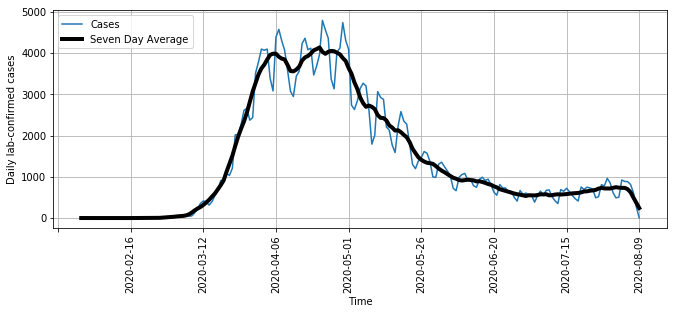

In [10]:
fig = plt.figure(figsize=(11, 4))
ax  = fig.add_subplot(111)
plt.plot(time_values,vert_values,label="Cases")
plt.plot(time_values,sevenDayAv,'k',label="Seven Day Average",linewidth=4)

plt.xlabel('Time')
plt.ylabel('Daily lab-confirmed cases')
ax.tick_params(axis='x', rotation=90)
ax.xaxis.set_major_locator(ticker.AutoLocator())
ax.invert_xaxis()
plt.legend(loc="upper left")
plt.grid()


The question (as of the 5th of August 2020) is if the cases are increasing, thus hinting a second wave coming. Let's zoom in to have a better look:

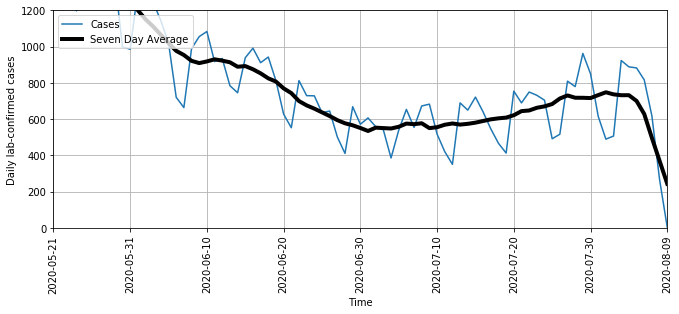

In [11]:
ax.set_xlim(0,80)
ax.set_ylim(0,1200)
ax.invert_xaxis()
fig

It does seem that the cases are going up. Let's look at deaths:

In [12]:
time_axisD = deaths_csv.loc[deaths_csv['Area type']=='UK',['Reporting date']]
vert_axisD = deaths_csv.loc[deaths_csv['Area type']=='UK',['Daily change in deaths']]
time_valuesD = time_axisD['Reporting date'];
vert_valuesD = vert_axisD['Daily change in deaths']
sevenDayAvD  = np.convolve(vert_valuesD,np.ones(7,)/7, mode='same')

In [13]:
len(time_valuesD)

219

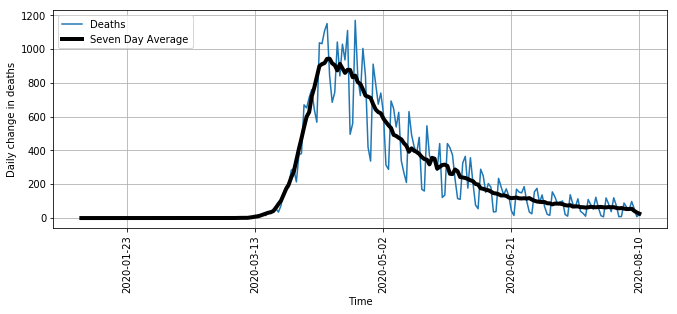

In [14]:
fig2 = plt.figure(figsize=(11, 4))
ax2  = fig2.add_subplot(111)
plt.plot(time_valuesD,vert_valuesD,label="Deaths")
plt.plot(time_valuesD,sevenDayAvD,'k',label="Seven Day Average",linewidth=4)

plt.xlabel('Time')
plt.ylabel('Daily change in deaths')
ax2.tick_params(axis='x', rotation=90)
ax2.xaxis.set_major_locator(ticker.AutoLocator())
ax2.invert_xaxis()
plt.legend(loc="upper left")
plt.grid()


In this case, it does not seem that the deaths are rising, this may be due to several factors, better knowledge of the disease and treatment, or simply that the new cases will develop and then in 2-3 weeks time the deaths will start rising.

Now, let's look at some regions. For the sake of analysis I have selected nine different regions:

In [15]:
testRegions=['Adur','Barrow-in-Furness','Carlisle','Guildford','Mid Sussex',
     'North Devon','New Forest','Stafford','Worthing']

Now I am going to display each of them in a separate subplot. So that they are easy to compare visually, let's set all to have the same vertical axis.

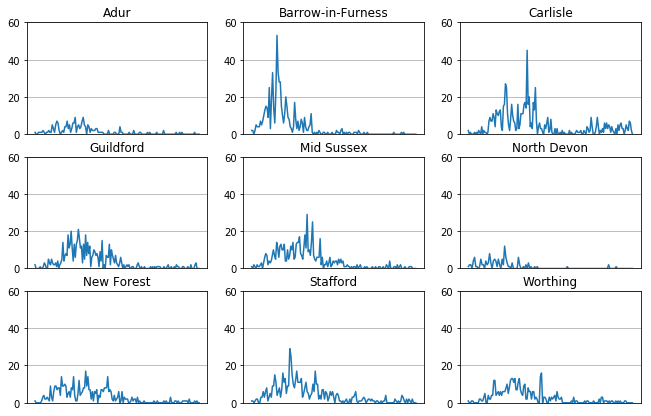

In [16]:
fig3 = plt.figure(figsize=(11, 7))

for counter in range(len(testRegions)):
    ax331  = fig3.add_subplot(3,3,counter+1)
    plt.plot(cases_csv.loc[cases_csv['Area name']==testRegions[counter],['Daily lab-confirmed cases']]) 
    plt.grid()
    ax331.invert_xaxis()
    ax331.set_ylim(0,60)
    ax331.set_title(testRegions[counter])
    ax331.set_xticks([])

Some names (e.g. Coventry) appear both in the upper tier and lower tier local authority, thus if we do not distinguish between these and try to display, it does not work:

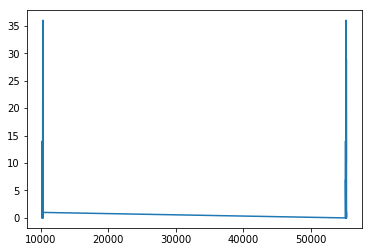

In [17]:
plt.plot(cases_csv.loc[cases_csv['Area name']=='Coventry',['Daily lab-confirmed cases']]) 

What we see is that there are cases of Coventry around the rows 10,000 and 50,000 of the csv file and the rest is empty. Thus we need to select over two columns to make the correct selection. E.g. for lower tier:

In [18]:
(cases_csv['Area type']=='ltla')&(cases_csv['Area name']=='Coventry')

0        False
1        False
2        False
3        False
4        False
5        False
6        False
7        False
8        False
9        False
10       False
11       False
12       False
13       False
14       False
15       False
16       False
17       False
18       False
19       False
20       False
21       False
22       False
23       False
24       False
25       False
26       False
27       False
28       False
29       False
         ...  
74460    False
74461    False
74462    False
74463    False
74464    False
74465    False
74466    False
74467    False
74468    False
74469    False
74470    False
74471    False
74472    False
74473    False
74474    False
74475    False
74476    False
74477    False
74478    False
74479    False
74480    False
74481    False
74482    False
74483    False
74484    False
74485    False
74486    False
74487    False
74488    False
74489    False
Length: 74490, dtype: bool

And the actual values are extracted like this:

In [19]:
cases_csv.loc[(cases_csv['Area type']=='ltla')&(cases_csv['Area name']=='Coventry'),['Daily lab-confirmed cases']]

,Daily lab-confirmed cases
10226,0
10227,3
10228,7
10229,10
10230,9
10231,5
10232,8
10233,6
10234,7
10235,6


In [20]:
cases_csv.loc[(cases_csv['Area type']=='utla')&(cases_csv['Area name']=='Coventry'),['Daily lab-confirmed cases']]

,Daily lab-confirmed cases
55139,0
55140,3
55141,7
55142,10
55143,9
55144,5
55145,8
55146,6
55147,7
55148,6


We can now display, and let's compare two different local authorities, Coventry and Leicester

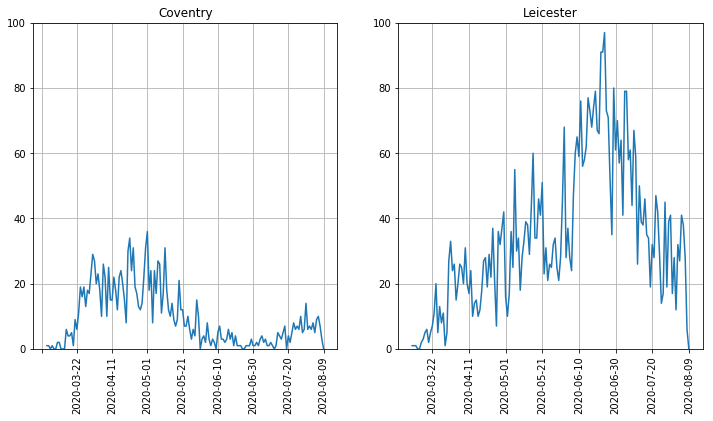

In [23]:
fig4 = plt.figure(figsize=(13, 6))

index_ltla_Coventry = (cases_csv['Area type']=='ltla')&(cases_csv['Area name']=='Coventry')
index_ltla_Leicester = (cases_csv['Area type']=='ltla')&(cases_csv['Area name']=='Leicester')
time_Coventry = cases_csv.loc[index_ltla_Coventry,['Specimen date']]
time_Leicester = cases_csv.loc[index_ltla_Leicester,['Specimen date']]#time_values = time_axis['Specimen date'];
ax211  = fig4.add_subplot(1,2,1)
plt.plot(time_Coventry['Specimen date'], cases_csv.loc[index_ltla_Coventry,['Daily lab-confirmed cases']]) 
plt.grid()
ax211.invert_xaxis()
ax211.set_ylim(0,100)
ax211.set_title('Coventry')
ax211.tick_params(axis='x', rotation=90)
ax211.xaxis.set_major_locator(ticker.AutoLocator())


ax212  = fig4.add_subplot(1,2,2)
plt.plot(time_Leicester['Specimen date'],cases_csv.loc[index_ltla_Leicester,['Daily lab-confirmed cases']]) 
plt.grid()
ax212.invert_xaxis()
ax212.set_ylim(0,100)
ax212.set_title('Leicester')
ax212.tick_params(axis='x', rotation=90)
ax212.xaxis.set_major_locator(ticker.AutoLocator())


The growth of Leicester is significant as compared with Coventry. But then, Leicester has come down whilst Coventry seems to be starting to go up.

In [55]:
LocalAuthorities=pd.Series.unique(cases_csv.loc[cases_csv['Area type']=='utla', 'Area name'])
len(LocalAuthorities)

149

In [56]:
LocalAuthorities

array(['Barking and Dagenham', 'Barnet', 'Barnsley',
       'Bath and North East Somerset', 'Bedford', 'Bexley', 'Birmingham',
       'Blackburn with Darwen', 'Blackpool', 'Bolton',
       'Bournemouth, Christchurch and Poole', 'Bracknell Forest',
       'Bradford', 'Brent', 'Brighton and Hove', 'Bristol, City of',
       'Bromley', 'Buckinghamshire', 'Bury', 'Calderdale',
       'Cambridgeshire', 'Camden', 'Central Bedfordshire',
       'Cheshire East', 'Cheshire West and Chester',
       'Cornwall and Isles of Scilly', 'County Durham', 'Coventry',
       'Croydon', 'Cumbria', 'Darlington', 'Derby', 'Derbyshire', 'Devon',
       'Doncaster', 'Dorset', 'Dudley', 'Ealing',
       'East Riding of Yorkshire', 'East Sussex', 'Enfield', 'Essex',
       'Gateshead', 'Gloucestershire', 'Greenwich',
       'Hackney and City of London', 'Halton', 'Hammersmith and Fulham',
       'Hampshire', 'Haringey', 'Harrow', 'Hartlepool', 'Havering',
       'Herefordshire, County of', 'Hertfordshire', 'Hil